# EXAMPLES

```
date: 2024-12-18
authors:
    - name: Brookie Guzder-Williams
affiliations:
    - University of California Berkeley, The Eric and Wendy Schmidt Center for Data Science & Environment
license: CC-BY-4.0
```

This notebook gives examples of how to use DSE's [Spectral Trend Database](https://github.com/SchmidtDSE/spectral_trend_database).  In particular we look at:

1. Querying the Database
2. Parsing the data
3. Visualizing the data


---

### IMPORTS


In [55]:
from importlib import reload
from pprint import pprint
import matplotlib.pyplot as plt
from google.cloud import bigquery as bq
from spectral_trend_database.config import config as c
from spectral_trend_database import query
from spectral_trend_database import utils


---

### CONFIG

In [2]:
BQ_PREFIX = 'dse-regenag.BiomassTrends'
SAMPLE_FRAC = 0.0005
YEAR_START = 2008
YEAR_END = 2020
START_MMDD = '11-01'
END_MMDD = START_MMDD
ATTR_COLS = [
    'sample_id',
    'lon',
    'lat']
LIST_ATTRS = [
    'year',
    'biomass',
    'crop_type']
CHART_DATA_PATH = 'spectral_trends.chart_data.json'


---

### HELPER METHODS


In [3]:
def print_list(lst, max_len=7, view_size=3, sep=', ', connector=' ... '):
    size = len(lst)
    if size <= max_len:
        lst_str = sep.join(lst)
    else:
        head = sep.join(lst[:view_size])        
        tail = sep.join(lst[-view_size:])
        lst_str = f'{head}{connector}{tail}  [{size}]'
    print(lst_str)

def line(marker='-', length=100):
    print(marker*length)

## DATABSE QUERIES

---

### STDB DATABASE INFO

First we'll take a quick peak at the what is in the STDB database

In [4]:
YIELD_TABLE = 'SCYM_YIELD'
SMOOTHED_INDICES_TABLE = 'SMOOTHED_INDICES_V1'
IDENT_DATE_COLUMNS = ['sample_id', 'year', 'date']

In [5]:
COLUMN_NAMES = {}
print('DATABASE INFO')
line()
query = reload(query)
table_names = query.table_names()
print('TABLES:')
pprint(table_names)
for table_name in [YIELD_TABLE, SMOOTHED_INDICES_TABLE]:
    COLUMN_NAMES[table_name] = query.column_names(table_name, run_query=True)
    print(f'\n{table_name}:')
    print_list(COLUMN_NAMES[table_name])
line()

DATABASE INFO
----------------------------------------------------------------------------------------------------
TABLES:
['SMOOTHED_INDICES_V1',
 'INDICES_STATS_V1',
 'LANDSAT_RAW_MASKED',
 'RAW_INDICES_V1',
 'SAMPLE_POINTS',
 'INDICES_STATS_V1_GROWING_SEASON',
 'INDICES_STATS_V1_OFF_SEASON',
 'ADMINISTRATIVE_BOUNDARIES',
 'SCYM_YIELD',
 'MACD_INDICES_V1']

SCYM_YIELD:
biomass, crop_type, year, sample_id

SMOOTHED_INDICES_V1:
ndbr, ndvi, grvi ... sample_id, rdvi, year  [39]
----------------------------------------------------------------------------------------------------


In [6]:
INDICES = [c for c in COLUMN_NAMES[SMOOTHED_INDICES_TABLE] if c not in IDENT_DATE_COLUMNS]
print_list(INDICES)

ndbr, ndvi, grvi ... si, nli, rdvi  [36]



---

### USING BIG QUERY

The data is in a big-query database, and so can be accessed using the big-query api

In [7]:
#| label: nb.example_query_bq

client = bq.Client()
sql = 'SELECT sample_id, date, ndvi FROM `dse-regenag.BiomassTrends.RAW_INDICES_V1` LIMIT 3'
resp = client.query(sql)
resp.to_dataframe()

,sample_id,date,ndvi
0,9yxczbreek2,"[1999-09-06T00:00:00.000000000, 1999-09-14T00:...","[0.3703811406, 0.3729185684, 0.4012729594, 0.3..."
1,dp09vpybreb,"[1999-09-06T00:00:00.000000000, 1999-09-14T00:...","[0.8879086908, 0.7770522225, 0.5581912105, 0.2..."
2,dp0cg0t74v4,"[1999-09-06T00:00:00.000000000, 1999-09-14T00:...","[0.4050935159, 0.2672095268, 0.1998820254, 0.1..."



---

### QueryConstructor and Helper Methods

Using big-query directly is easy enough.  However, constructing SQL statements with lots of `JOINS` and `WHERE` statements can be painful.  To handle this we've developed a simple QueryConstructor. Additionaly we've added a few convience methods 
so the user never needs to use the big-query python module directly.  You've already seen two of them: `query.table_names` and `query.column_names`.

Let's start by reproducing the SQL in our simple example above

In [13]:
#| label: nb.example_query_stdb_basic

qc = query.QueryConstructor('RAW_INDICES_V1', table_prefix=BQ_PREFIX)
qc.select('sample_id', 'date', 'ndvi')
qc.limit(3)
df = query.run(sql=qc.sql())

print(qc.sql(),'\n')
df

SELECT sample_id, date, ndvi FROM `dse-regenag.BiomassTrends.RAW_INDICES_V1` LIMIT 3 



,sample_id,date,ndvi
0,9yxczbreek2,"[1999-09-06T00:00:00.000000000, 1999-09-14T00:...","[0.3703811406, 0.3729185684, 0.4012729594, 0.3..."
1,dp09vpybreb,"[1999-09-06T00:00:00.000000000, 1999-09-14T00:...","[0.8879086908, 0.7770522225, 0.5581912105, 0.2..."
2,dp0cg0t74v4,"[1999-09-06T00:00:00.000000000, 1999-09-14T00:...","[0.4050935159, 0.2672095268, 0.1998820254, 0.1..."


Now we'll create an more complicated request using the sample_ids  from the above example.

First I'll need to reformat the sample_ids into something I can use in a `JOIN` statement

In [9]:
sample_ids = df.sample_id.tolist()
sample_ids = [f"'{s}'" for s in sample_ids]
sample_ids = f'({", ".join(sample_ids)})'
sample_ids

"('9yxczbreek2', 'dp09vpybreb', 'dp0cg0t74v4')"

In [69]:
#| label: nb.example_query_stdb_advanced

qc = query.QueryConstructor(
        'SAMPLE_POINTS', 
        table_prefix=BQ_PREFIX,
        using=['sample_id'],  
        how='inner')
qc.join('MACD_INDICES_V1')
qc.join('SMOOTHED_INDICES_V1', 'sample_id', 'year')
qc.where(sample_id=sample_ids, sample_id_op='in')
qc.where('SMOOTHED_INDICES_V1', year=2012, year_op='>=')
qc.where('SMOOTHED_INDICES_V1', year=2016, year_op='<')
df = query.run(sql=qc.sql())
df = df.sort_values(by='year')
example_id = df.sample_id.sample().iloc[0]

print(qc.sql(),'\n')
df[df.sample_id == example_id]

SELECT * FROM `dse-regenag.BiomassTrends.SAMPLE_POINTS` INNER JOIN `dse-regenag.BiomassTrends.MACD_INDICES_V1` USING (sample_id) INNER JOIN `dse-regenag.BiomassTrends.SMOOTHED_INDICES_V1` USING (sample_id, year) WHERE `dse-regenag.BiomassTrends.SAMPLE_POINTS`.sample_id in ('9yxczbreek2', 'dp09vpybreb', 'dp0cg0t74v4') AND `dse-regenag.BiomassTrends.SMOOTHED_INDICES_V1`.year >= 2012 AND `dse-regenag.BiomassTrends.SMOOTHED_INDICES_V1`.year < 2016 



,sample_id,year,geohash_5,geohash_7,geohash_9,lon,lat,macd_evi2,macd_ndvi,macd_div_evi2,...,msr,tvi,si1,rvi,tdvi,osavi,si,nli,date_1,rdvi
5,dp09vpybreb,2013,dp09v,dp09vpy,dp09vpybr,-89.067556,39.725253,"[0.0, 0.0, 0.0, 0.0, 0.0, -0.00101025827198039...","[0.0, 0.0, 0.0, 0.0, 2.7755575615628914e-17, -...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.00067350551465359...",...,"[0.21585871676236207, 0.2158087588953088, 0.21...","[0.8325144796797004, 0.8324762162293166, 0.832...","[0.12452208807148246, 0.12206445939573561, 0.1...","[1.4781892284097613, 1.4781043683113648, 1.477...","[0.12325827096712844, 0.12089114398585654, 0.1...","[0.13376780623679888, 0.1323160045749384, 0.13...","[0.10661246136450904, 0.10446274076207933, 0.1...","[-0.5255502776249459, -0.5340414996333778, -0....","[2012-09-09T00:00:00.000000000, 2012-09-10T00:...","[0.1148986977720395, 0.11344616960290449, 0.11..."
6,dp09vpybreb,2014,dp09v,dp09vpy,dp09vpybr,-89.067556,39.725253,"[0.0, 0.0, 0.0, 0.0, 0.0, -0.00655035818173516...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.00442511850283078...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.00436690545449010...",...,"[2.2985921999153787, 2.150515350034608, 2.0104...","[1.011420698998772, 1.008910653991155, 1.00634...","[0.18868780984010947, 0.1919468848715948, 0.19...","[13.2430036172639, 12.258938309058053, 11.3312...","[0.546145588533324, 0.5300254966610662, 0.5143...","[0.45261276336532547, 0.4426537184260072, 0.43...","[0.18357161646986456, 0.1858872947263696, 0.18...","[0.5487700865546953, 0.5089648670712584, 0.469...","[2013-09-04T00:00:00.000000000, 2013-09-05T00:...","[0.43417808207279773, 0.4234290154449349, 0.41..."
4,dp09vpybreb,2015,dp09v,dp09vpy,dp09vpybr,-89.067556,39.725253,"[0.0, 0.0, 0.0, 0.0, 0.0, -0.01754069112701073...","[0.0, 0.0, 0.0, 0.0, 1.1102230246251565e-16, -...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.01169379408467382...",...,"[2.8776486266618595, 2.6858267660808894, 2.503...","[1.2041700580038948, 1.1844724833386193, 1.165...","[0.028869416852003112, 0.03536852733381104, 0....","[14.439222789525303, 13.430519470900844, 12.47...","[0.8143607955174588, 0.770939090769372, 0.7293...","[0.7082217433088875, 0.6746871633318255, 0.642...","[0.0075689821245091835, 0.014197808715539165, ...","[0.8290053058729269, 0.7467695166949675, 0.667...","[2014-09-07T00:00:00.000000000, 2014-09-08T00:...","[0.6641783905065816, 0.6309188598338108, 0.598..."


# PARSING THE DATA

---


Using the [utils](/docs/spectral_trend_database/spectral_trend_database.utils.html) module we can easily turn these rows into xarray-datasets to more easily parse interact with the data.   

In [70]:
ATTR_COLS = [
    'sample_id',
    'lon',
    'lat']
LIST_ATTRS = [
    'year']
START_MMDD = '12-01'
END_MMDD = START_MMDD

In [71]:
#| label: nb.parsing_single_row

row = df.sample().iloc[0]
utils.row_to_xr(
    row, 
    coord='date', 
    attrs=ATTR_COLS + LIST_ATTRS)

<xarray.Dataset>
Dimensions:        (date: 440)
Coordinates:
  * date           (date) datetime64[ns] 2012-09-09 2012-09-10 ... 2013-11-22
Data variables: (12/52)
    macd_evi2      (date) float64 0.0 0.0 0.0 ... 4.974e-05 -0.0005633 -0.001279
    macd_ndvi      (date) float64 0.0 0.0 0.0 0.0 ... 0.02774 0.02898 0.03017
    macd_div_evi2  (date) float64 0.0 0.0 0.0 ... -0.0008099 -0.001017
    macd_div_evi   (date) float64 0.0 0.0 0.0 0.0 ... 0.002457 0.002404 0.002354
    ema_c_evi2     (date) float64 0.0 0.0 0.0 ... 0.0006515 0.0002466 -0.0002618
    ema_c_evi      (date) float64 0.0 0.0 0.0 0.0 ... 0.02317 0.02437 0.02555
    ...             ...
    tdvi           (date) float64 0.1878 0.186 0.1842 ... 0.1141 0.1107 0.1065
    osavi          (date) float64 0.196 0.1895 0.1836 ... 0.2082 0.2124 0.2163
    si             (date) float64 0.07934 0.09708 0.1135 ... -0.06853 -0.08124
    nli            (date) float64 -0.4162 -0.4045 -0.3936 ... -0.7508 -0.7733
    date_1         (date) datetime64[ns] 2012-09-09 2012-09-10 ... 2013-11-22
    rdvi           (date) float64 0.1706 0.1668 0.1633 ... 0.1572 0.1585 0.1595
Attributes:
    sample_id:  9yxczbreek2
    lon:        -90.0005470356
    lat:        36.8721148696
    year:       2013

We simialarly turn multiple rows into a dataset. Because rows contain overlaping dates we'll also need to filter the dates using the `filter_dates` method below:

In [72]:
#| label: nb.parsing_multiple_rows

def filter_dates(row):
    return dict(date=slice(f'{row.year-1}-{START_MMDD}', f'{row.year}-{END_MMDD}'))

rows = df[df.sample_id == example_id].sort_values(by='year')
ds = utils.rows_to_xr(
    rows, 
    coord='date', 
    sel=filter_dates, 
    attr_cols=ATTR_COLS,
    list_attrs=LIST_ATTRS)

display(ds)

<xarray.Dataset>
Dimensions:        (date: 1072)
Coordinates:
  * date           (date) datetime64[ns] 2012-12-01 2012-12-02 ... 2015-11-28
Data variables: (12/52)
    macd_evi2      (date) float64 1.124e-05 1.472e-05 ... 0.02117 0.02284
    macd_ndvi      (date) float64 -0.002579 -0.002682 ... 0.05329 0.05705
    macd_div_evi2  (date) float64 -2.976e-05 -1.752e-05 ... 0.003105 0.003188
    macd_div_evi   (date) float64 0.0001843 0.0004223 ... 0.04581 0.04731
    ema_c_evi2     (date) float64 4.1e-05 3.224e-05 ... 0.01806 0.01966
    ema_c_evi      (date) float64 -0.005743 -0.005532 ... 0.1878 0.2115
    ...             ...
    tdvi           (date) float64 0.07117 0.07124 0.07134 ... 0.2051 0.2185
    osavi          (date) float64 0.1068 0.1067 0.1066 ... 0.2685 0.2864 0.3054
    si             (date) float64 0.06198 0.06212 0.06207 ... -0.07429 -0.09373
    nli            (date) float64 -0.7216 -0.7213 -0.7212 ... -0.5686 -0.5599
    date_1         (date) datetime64[ns] 2012-12-01 2012-12-02 ... 2015-11-28
    rdvi           (date) float64 0.08572 0.08558 0.08549 ... 0.2295 0.2445
Attributes:
    sample_id:  dp09vpybreb
    lon:        -89.0675559449
    lat:        39.7252528422
    year:       [2013, 2014, 2015]


---

## Computations and Visulaizations


In [162]:
SUPTITLE = 'Spectral Trends'
TITLE = 'Normalized Difference Vegetation Index and Exponentially Weighted Moving Average'
SUPTITLE_FONT_SIZE = 22
SUPTITLE_CLR = '#555'
TITLE_FONT_SIZE = 14
TITLE_CLR = '#999'
LABEL_FONT_SIZE = 16
LABEL_CLR = '#333'

In [163]:
def twinx_legend(ax, ax2):
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    return ax2.legend(lines + lines2, labels + labels2, loc=0)

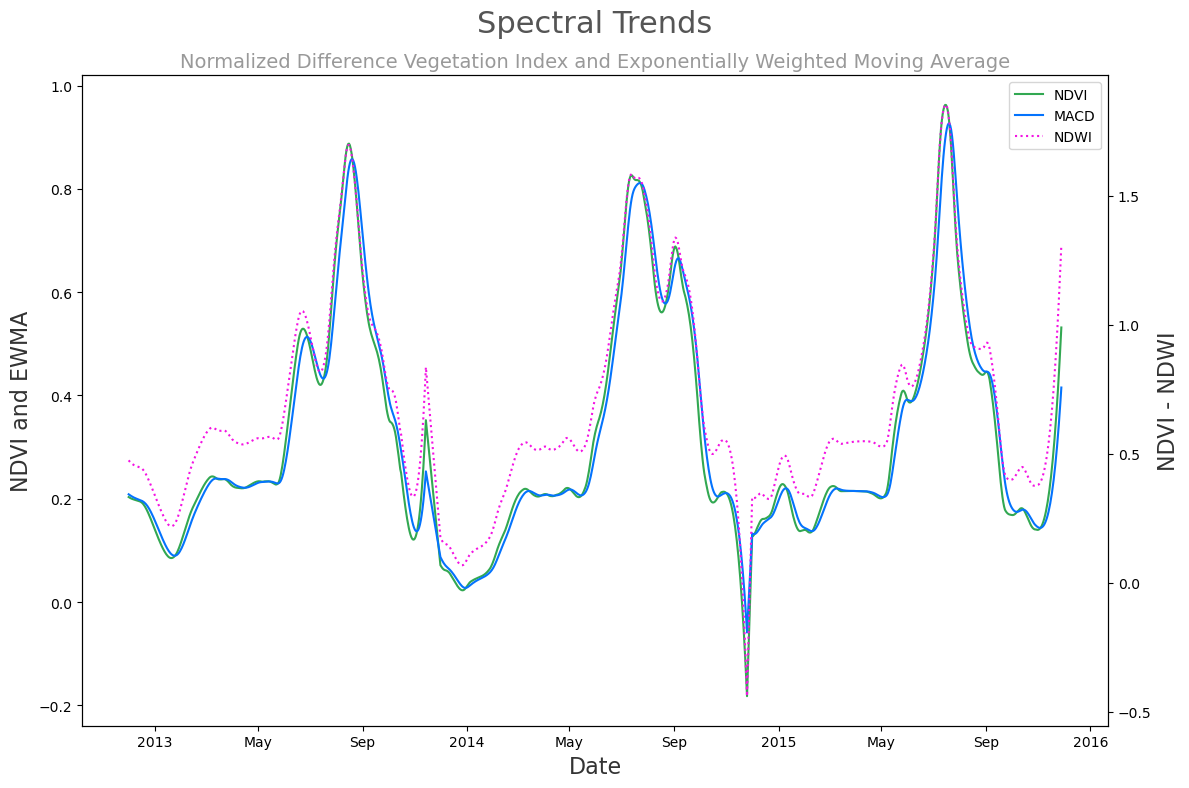

In [177]:
#| label: nb.ndvi_vs_ema

fig, ax = plt.subplots(figsize=(12, 8))
ax2 = ax.twinx()

ds.ndvi.plot(color='#32a852', label='NDVI', ax=ax)
ds.ema_b_ndvi.plot(color='#0473fd', label='MACD', ax=ax)
(ds.ndvi - ds.ndwi).plot(color='#f413e3', linestyle='dotted', label='NDWI', ax=ax2)

plt.title(TITLE,fontsize=TITLE_FONT_SIZE,color=TITLE_CLR)
plt.suptitle(SUPTITLE,fontsize=SUPTITLE_FONT_SIZE,color=SUPTITLE_CLR)

ax.set_ylabel('NDVI and EWMA', fontsize=LABEL_FONT_SIZE, color=LABEL_CLR)
ax2.set_ylabel('NDVI - NDWI', fontsize=LABEL_FONT_SIZE, color=LABEL_CLR)
ax.set_xlabel('Date', fontsize=LABEL_FONT_SIZE, color=LABEL_CLR)
twinx_legend(ax, ax2)

plt.tight_layout()